In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyreadr
import os
import pandas as pd


In [2]:


ICB_dir = "../../data/ICB_RECIST/"

# View one ICB data
#ICB_Liu = "../../data/ICB/ICB_Liu_filtered.RData"
#output = pyreadr.read_r(ICB_Liu)
    # each file contains two dataframes: clinical and expr with matched patient IDs
#clinical_df = output.get('clinical', None)
#rna_df = output.get('expr', None)

# generate summary for all ICB data by recist and response
summary_data = []

# Iterate over files in the directory
for file_name in os.listdir(ICB_dir):
    if file_name.endswith(".RData"):
        file_path = os.path.join(ICB_dir, file_name)
        
        try:
            result = pyreadr.read_r(file_path)

            clinical_df = result.get('clinical', None)
            rna_df = result.get('expr', None)

            if clinical_df is None or rna_df is None:
                print(f"Missing keys in {file_name}")
                continue

            # Get counts of 'recist' and 'response'
            recist_counts = clinical_df['recist'].value_counts().to_dict()
            data_no_recist = clinical_df[clinical_df['recist'].isna()]

            response_counts = clinical_df['response'].value_counts().to_dict()

            cancer_type = ', '.join(clinical_df['cancer_type'].dropna().unique())
            treatment = ', '.join(clinical_df['treatment'].dropna().unique())
            rna = ', '.join(clinical_df['rna'].dropna().unique())
            total_patients = clinical_df.shape[0]

            # Store summary
            summary_data.append({
                'File': file_name,
                'Cancer_Type': cancer_type,
                'Treatment': treatment,
                'RNA': rna,
                'Total_Patients': total_patients,
                'Recist_Counts': recist_counts,
                'Response_Counts': response_counts,
            })

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.join(summary_df.pop('Recist_Counts').apply(pd.Series).add_prefix('Recist_'))
summary_df = summary_df.join(summary_df.pop('Response_Counts').apply(pd.Series).add_prefix('Response_'))

## MELANOMA DATA ANALYSIS


In [3]:
filtered_df_melanoma = summary_df[
    (summary_df['Cancer_Type'] == 'Melanoma') &
    (summary_df['Treatment'].str.contains('PD-1', na=False))
]

print(filtered_df_melanoma["File"])



1           ICB_Gide_filtered.RData
2           ICB_Hugo_filtered.RData
3    ICB_Jerby_Arnon_filtered.RData
5            ICB_Liu_filtered.RData
8           ICB_Puch_filtered.RData
9           ICB_Riaz_filtered.RData
Name: File, dtype: object


In [4]:
import scanpy as sc
import anndata as ad

# Initialize lists to store combined data
all_clinical_data = []
all_rna_data = []
batch_labels = []

# Process each melanoma dataset

for idx, file_name in enumerate(filtered_df_melanoma['File']):
    file_path = os.path.join(ICB_dir, file_name)
    print(f"Processing {file_name}...")
    
    # Read the data
    result = pyreadr.read_r(file_path)
    clinical_df = result.get('clinical', None)
    rna_df = result.get('expr', None)
    
    if clinical_df is None or rna_df is None:
        print(f"Missing data in {file_name}, skipping...")
        continue
        
    print(f"  {clinical_df['recist']}")  # target value

    # Ensure both dataframes have the same patients (in case of any mismatch)
    common_patients = clinical_df.index.intersection(rna_df.index)
    clinical_subset = clinical_df.loc[common_patients]
    rna_subset = rna_df.loc[common_patients]
    
    print(f"  - {len(common_patients)} patients")
    print(f"  - {rna_subset.shape[1]} genes")
    
    # Add batch information to clinical data
    clinical_subset = clinical_subset.copy()
    clinical_subset['batch'] = file_name.replace('_filtered.RData', '').replace('ICB_', '')
    
    # Store the data
    all_clinical_data.append(clinical_subset)
    all_rna_data.append(rna_subset)

print(f"\nProcessed {len(all_clinical_data)} datasets")

Processing ICB_Gide_filtered.RData...
  rownames
ERR2208929    PD
ERR2208930    PD
ERR2208931    SD
ERR2208933    PD
ERR2208934    PD
ERR2208935    PD
ERR2208936    PD
ERR2208938    PD
ERR2208939    PD
ERR2208940    SD
ERR2208941    PD
ERR2208942    SD
ERR2208943    SD
ERR2208945    PR
ERR2208946    PR
ERR2208948    SD
ERR2208949    PD
ERR2208951    PR
ERR2208952    PR
ERR2208953    PR
ERR2208954    PR
ERR2208956    PR
ERR2208958    PR
ERR2208959    CR
ERR2208960    PR
ERR2208961    PR
ERR2208962    PR
ERR2208964    PR
ERR2208966    PR
ERR2208967    CR
ERR2208968    PD
ERR2208969    CR
ERR2208970    PR
ERR2208971    CR
ERR2208972    PR
ERR2208973    PD
ERR2208974    PD
ERR2208977    PD
ERR3262563    SD
ERR3262564    PD
ERR3262565    PD
Name: recist, dtype: object
  - 41 patients
  - 61544 genes
Processing ICB_Hugo_filtered.RData...
  rownames
Pt1     PD
Pt2     PR
Pt4     PR
Pt5     PR
Pt6     PR
Pt7     PD
Pt8     CR
Pt9     CR
Pt10    PD
Pt12    PD
Pt13    CR
Pt14    PD
Pt15    PR
Pt

In [5]:
# Analyze gene overlap across batches
print("="*60)
print("GENE OVERLAP ANALYSIS ACROSS BATCHES")
print("="*60)

# Get gene sets for each batch
batch_genes = {}
for i, (clinical_data, rna_data) in enumerate(zip(all_clinical_data, all_rna_data)):
    batch_name = clinical_data['batch'].iloc[0]
    batch_genes[batch_name] = set(rna_data.columns)
    print(f"{batch_name}: {len(batch_genes[batch_name]):,} genes")

# Find common genes across all batches
all_batches = list(batch_genes.keys())
common_genes_all = set.intersection(*batch_genes.values())
print(f"\nGenes common to ALL batches: {len(common_genes_all):,}")

# Pairwise overlap analysis
print(f"\nPairwise gene overlap:")
overlap_matrix = pd.DataFrame(index=all_batches, columns=all_batches)

for i, batch1 in enumerate(all_batches):
    for j, batch2 in enumerate(all_batches):
        if i <= j:  # Only calculate upper triangle and diagonal
            overlap = len(batch_genes[batch1].intersection(batch_genes[batch2]))
            overlap_matrix.loc[batch1, batch2] = overlap
            if i != j:  # Don't print diagonal (same batch with itself)
                percentage = (overlap / min(len(batch_genes[batch1]), len(batch_genes[batch2]))) * 100
                print(f"  {batch1} ∩ {batch2}: {overlap:,} genes ({percentage:.1f}% of smaller set)")

# Show gene annotation patterns (to understand why overlap is low)
print(f"\nGene annotation patterns (first 5 genes per batch):")
for batch_name, genes in batch_genes.items():
    sample_genes = sorted(list(genes))[:5]
    print(f"  {batch_name}: {sample_genes}")

# Check if the issue is gene version differences
print(f"\nChecking for gene version differences...")
# Extract base gene IDs (remove version numbers)
batch_base_genes = {}
for batch_name, genes in batch_genes.items():
    base_genes = set()
    for gene in genes:
        if '.' in gene:
            base_gene = gene.split('.')[0]  # Remove version number
        else:
            base_gene = gene
        base_genes.add(base_gene)
    batch_base_genes[batch_name] = base_genes
    
# Find common base genes (without version numbers)
common_base_genes = set.intersection(*batch_base_genes.values())
print(f"Common base genes (ignoring versions): {len(common_base_genes):,}")

# Show improvement in overlap when ignoring versions
if len(common_base_genes) > len(common_genes_all):
    print(f"Improvement by ignoring versions: +{len(common_base_genes) - len(common_genes_all):,} genes")
else:
    print("Gene versions are not the main issue - different annotation systems are used")

print(f"\n" + "="*60)


# Summary and interpretation of gene overlap results
print("="*60)
print("GENE OVERLAP SUMMARY & INSIGHTS")
print("="*60)

print(f"   - Only {len(common_genes_all)} genes common across all batches")
print(f"   - But {len(common_base_genes):,} base genes when ignoring versions")



GENE OVERLAP ANALYSIS ACROSS BATCHES
Gide: 61,544 genes
Hugo: 61,544 genes
Jerby_Arnon: 587 genes
Liu: 20,212 genes
Puch: 18,789 genes
Riaz: 61,544 genes

Genes common to ALL batches: 2

Pairwise gene overlap:
  Gide ∩ Hugo: 61,544 genes (100.0% of smaller set)
  Gide ∩ Jerby_Arnon: 4 genes (0.7% of smaller set)
  Gide ∩ Liu: 20,212 genes (100.0% of smaller set)
  Gide ∩ Puch: 353 genes (1.9% of smaller set)
  Gide ∩ Riaz: 61,544 genes (100.0% of smaller set)
  Hugo ∩ Jerby_Arnon: 4 genes (0.7% of smaller set)
  Hugo ∩ Liu: 20,212 genes (100.0% of smaller set)
  Hugo ∩ Puch: 353 genes (1.9% of smaller set)
  Hugo ∩ Riaz: 61,544 genes (100.0% of smaller set)
  Jerby_Arnon ∩ Liu: 2 genes (0.3% of smaller set)
  Jerby_Arnon ∩ Puch: 546 genes (93.0% of smaller set)
  Jerby_Arnon ∩ Riaz: 4 genes (0.7% of smaller set)
  Liu ∩ Puch: 160 genes (0.9% of smaller set)
  Liu ∩ Riaz: 20,212 genes (100.0% of smaller set)
  Puch ∩ Riaz: 353 genes (1.9% of smaller set)

Gene annotation patterns (first

In [6]:

Files_remove = ["ICB_Jerby_Arnon_filtered.RData", "ICB_Puch_filtered.RData"]
for ele in Files_remove:
    
    filtered_df_melanoma = filtered_df_melanoma[filtered_df_melanoma['File'] != ele]

In [7]:
import scanpy as sc
import anndata as ad

# Initialize lists to store combined data
all_clinical_data = []
all_rna_data = []
batch_labels = []

# Process each melanoma dataset

for idx, file_name in enumerate(filtered_df_melanoma['File']):
    file_path = os.path.join(ICB_dir, file_name)
    print(f"Processing {file_name}...")
    
    # Read the data
    result = pyreadr.read_r(file_path)
    clinical_df = result.get('clinical', None)
    rna_df = result.get('expr', None)
    
    if clinical_df is None or rna_df is None:
        print(f"Missing data in {file_name}, skipping...")
        continue
    
    # Ensure both dataframes have the same patients (in case of any mismatch)
    common_patients = clinical_df.index.intersection(rna_df.index)
    clinical_subset = clinical_df.loc[common_patients]
    rna_subset = rna_df.loc[common_patients]
    
    print(f"  - {len(common_patients)} patients")
    print(f"  - {rna_subset.shape[1]} genes")
    
    # Add batch information to clinical data
    clinical_subset = clinical_subset.copy()
    clinical_subset['batch'] = file_name.replace('_filtered.RData', '').replace('ICB_', '')
    
    # Store the data
    all_clinical_data.append(clinical_subset)
    all_rna_data.append(rna_subset)

print(f"\nProcessed {len(all_clinical_data)} datasets")

Processing ICB_Gide_filtered.RData...
  - 41 patients
  - 61544 genes
Processing ICB_Hugo_filtered.RData...
  - 27 patients
  - 61544 genes
Processing ICB_Liu_filtered.RData...
  - 121 patients
  - 20212 genes
Processing ICB_Riaz_filtered.RData...
  - 46 patients
  - 61544 genes

Processed 4 datasets


In [8]:
# Find common genes across all batches first
print("="*60)
print("FINDING COMMON GENES ACROSS ALL BATCHES")
print("="*60)

# Get gene sets for each batch
batch_genes = {}
for i, (clinical_data, rna_data) in enumerate(zip(all_clinical_data, all_rna_data)):
    batch_name = clinical_data['batch'].iloc[0]
    batch_genes[batch_name] = set(rna_data.columns)
    print(f"{batch_name}: {len(batch_genes[batch_name]):,} genes")

# Find common genes across all batches
all_batches = list(batch_genes.keys())
common_genes_all = set.intersection(*batch_genes.values())
print(f"\nGenes common to ALL batches: {len(common_genes_all):,}")

# Convert to sorted list for consistent ordering
common_genes_list = sorted(list(common_genes_all))

print("="*60)
print("COMBINING DATASETS WITH COMMON GENES ONLY")
print("="*60)

# Combine datasets using only common genes
rna_combined_list = []
clinical_combined_list = []

for clinical_data, rna_data in zip(all_clinical_data, all_rna_data):
    # Filter to only common genes
    rna_filtered = rna_data[common_genes_list]
    
    # Add patient IDs as a prefix to avoid duplicates across batches
    batch_name = clinical_data['batch'].iloc[0]
    new_index = [f"{batch_name}_{patient_id}" for patient_id in rna_filtered.index]
    
    # Make copies and update indices
    rna_copy = rna_filtered.copy()
    clinical_copy = clinical_data.copy()
    
    rna_copy.index = new_index
    clinical_copy.index = new_index
    
    rna_combined_list.append(rna_copy)
    clinical_combined_list.append(clinical_copy)
    
    print(f"{batch_name}: {len(rna_copy)} patients × {len(common_genes_list)} common genes")

# Combine data (inner join since all datasets have the same genes now)
rna_combined = pd.concat(rna_combined_list, axis=0)
clinical_combined = pd.concat(clinical_combined_list, axis=0)

print(f"\nFinal combined data:")
print(f"RNA data shape: {rna_combined.shape}")
print(f"Clinical data shape: {clinical_combined.shape}")
print(f"Common genes used: {rna_combined.shape[1]:,}")
print(f"No NaN values (all genes present in all batches)")
print("="*60)

FINDING COMMON GENES ACROSS ALL BATCHES
Gide: 61,544 genes
Hugo: 61,544 genes
Liu: 20,212 genes
Riaz: 61,544 genes

Genes common to ALL batches: 20,212
COMBINING DATASETS WITH COMMON GENES ONLY
Gide: 41 patients × 20212 common genes
Hugo: 27 patients × 20212 common genes
Liu: 121 patients × 20212 common genes
Riaz: 46 patients × 20212 common genes

Final combined data:
RNA data shape: (235, 20212)
Clinical data shape: (235, 95)
Common genes used: 20,212
No NaN values (all genes present in all batches)


C:\Users\Marcos\AppData\Local\Temp\ipykernel_4120\2814690191.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clinical_combined = pd.concat(clinical_combined_list, axis=0)


In [9]:
# Create AnnData object with common genes only
adata = ad.AnnData(X=rna_combined.values, obs=clinical_combined)
adata.var_names = rna_combined.columns
adata.obs_names = rna_combined.index

# Clean up data types for saving
print("Cleaning data types...")

# Convert numeric columns
numeric_cols = ['age', 'survival_time_pfs', 'survival_time_os', 'TMB_raw', 'nsTMB_raw', 
                'TMB_perMb', 'nsTMB_perMb', 'CIN', 'CNA_tot', 'AMP', 'DEL', 
                'event_occurred_pfs', 'event_occurred_os']

for col in numeric_cols:
    if col in adata.obs.columns:
        adata.obs[col] = pd.to_numeric(adata.obs[col], errors='coerce')

# Convert object columns to string, handling NaN properly
for col in adata.obs.columns:
    if adata.obs[col].dtype == 'object':
        adata.obs[col] = adata.obs[col].astype(str)
        adata.obs[col] = adata.obs[col].replace('nan', None)

print(f"AnnData object created with common genes:")
print(f"Shape: {adata.shape} (patients × genes)")
print(f"Batches: {adata.obs['batch'].value_counts().to_dict()}")
print(f"Response: {adata.obs['recist'].value_counts().to_dict()}")
print(f"Data type: {adata.X.dtype}")
print(f"NaN values: {np.isnan(adata.X).sum()} (should be 0)")
print(f"Min expression: {adata.X.min():.2f}")
print(f"Max expression: {adata.X.max():.2f}")

# Verify no missing data
print(f"\n✓ All genes present in all batches")
print(f"✓ No missing data (NaN values)")
print(f"✓ Ready for analysis without missing data concerns")





Cleaning data types...
AnnData object created with common genes:
Shape: (235, 20212) (patients × genes)
Batches: {'Liu': 121, 'Riaz': 46, 'Gide': 41, 'Hugo': 27}
Response: {'PD': 106, 'PR': 62, 'SD': 38, 'CR': 27}
Data type: float64
NaN values: 0 (should be 0)
Min expression: -9.97
Max expression: 17.98

✓ All genes present in all batches
✓ No missing data (NaN values)
✓ Ready for analysis without missing data concerns


In [10]:

genes = pd.read_csv("../../data/common_genes_cosmic_io.csv")


genes_to_select = genes["gene_id"].tolist()

# Filter adata to only include genes that are in the genes_to_select list
genes_in_adata = adata.var_names.intersection(genes_to_select)
print(f"Genes in common between adata and selection list: {len(genes_in_adata)}")
print(f"Original adata shape: {adata.shape}")

# Subset adata to only these genes
adata = adata[:, genes_in_adata]
print(f"Filtered adata shape: {adata.shape}")


Genes in common between adata and selection list: 223
Original adata shape: (235, 20212)
Filtered adata shape: (235, 223)


## Analysis


In [11]:
# Set up scanpy settings and copy data for analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Configure scanpy settings
sc.settings.verbosity = 3  # verbosity level
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Make a copy for analysis
adata_analysis = adata.copy()

print(f"Starting analysis with:")
print(f"- {adata_analysis.n_obs} patients")
print(f"- {adata_analysis.n_vars:,} genes")
print(f"- Batches: {list(adata_analysis.obs['batch'].unique())}")
print(f"- RECIST responses: {list(adata_analysis.obs['recist'].unique())}")

# Basic preprocessing for visualization
# Keep raw data for later
adata_analysis.raw = adata_analysis

# Filter genes and normalize for visualization
sc.pp.filter_genes(adata_analysis, min_cells=10)
print(f"After filtering: {adata_analysis.n_vars} genes")



print("✓ Data preprocessed for analysis")

Starting analysis with:
- 235 patients
- 223 genes
- Batches: ['Gide', 'Hugo', 'Liu', 'Riaz']
- RECIST responses: ['PD', 'SD', 'PR', 'CR', None]
filtered out 3 genes that are detected in less than 10 cells
After filtering: 220 genes
✓ Data preprocessed for analysis


IDENTIFYING HIGHLY VARIABLE GENES & PCA
Checking for NaN values in expression data...
NaN values found: 0
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


c:\Users\Marcos\anaconda3\envs\conformals3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\Marcos\anaconda3\envs\conformals3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\Marcos\anaconda3\envs\conformals3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:415: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


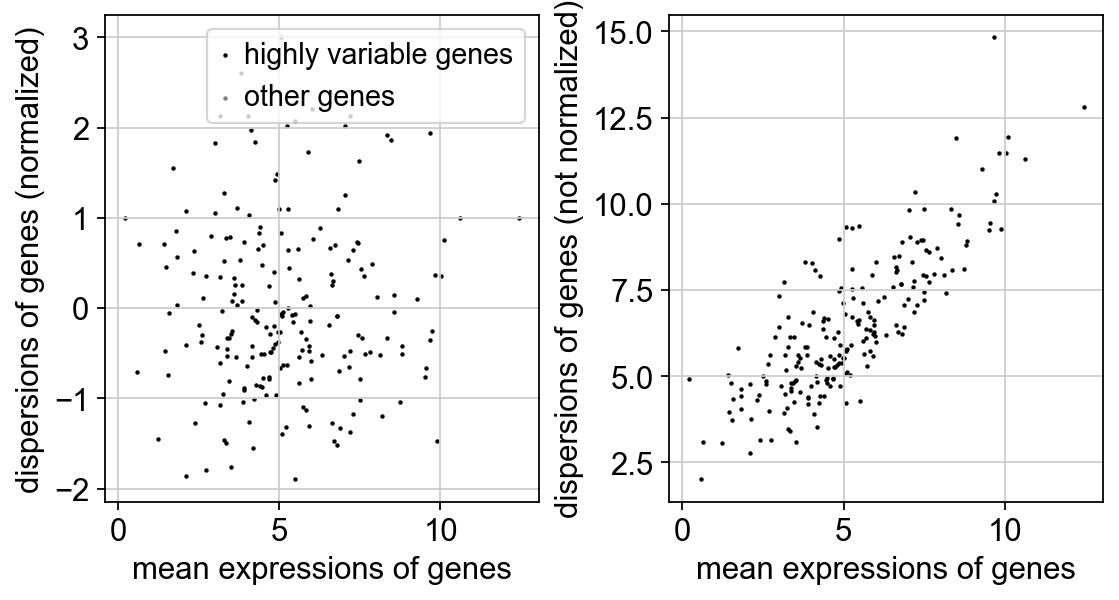

Highly variable genes found: 213
computing PCA
    with n_comps=50
    finished (0:00:00)


c:\Users\Marcos\anaconda3\envs\conformals3\lib\site-packages\scanpy\preprocessing\_pca\__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


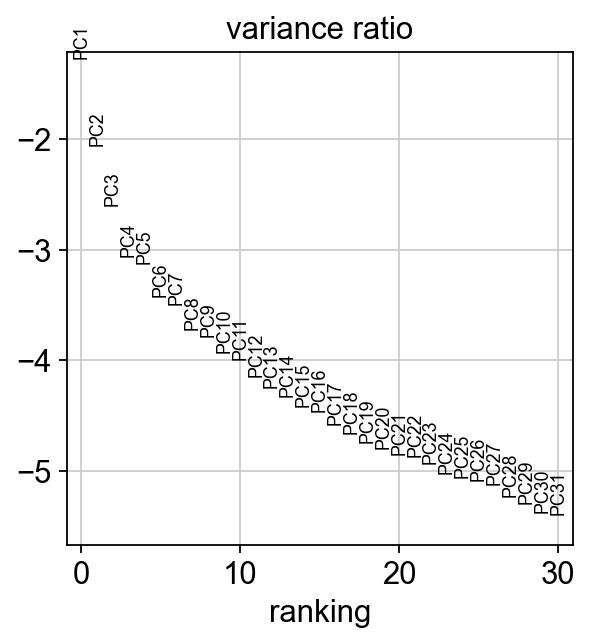

✓ PCA completed


In [12]:
# Identify highly variable genes and run PCA
print("="*50)
print("IDENTIFYING HIGHLY VARIABLE GENES & PCA")
print("="*50)

# Check for and handle any remaining NaN values
print(f"Checking for NaN values in expression data...")
n_nan = np.isnan(adata_analysis.X).sum()
print(f"NaN values found: {n_nan}")

if n_nan > 0:
    print("Replacing NaN values with 0...")
    adata_analysis.X = np.nan_to_num(adata_analysis.X, nan=0.0)

# Find highly variable genes with adjusted parameters for transcript data
sc.pp.highly_variable_genes(adata_analysis, min_mean=0.01, max_mean=5, min_disp=0.5, n_top_genes=220)
sc.pl.highly_variable_genes(adata_analysis)
plt.show()

print(f"Highly variable genes found: {sum(adata_analysis.var.highly_variable)}")

# Keep only highly variable genes for downstream analysis
adata_analysis.raw = adata_analysis  # Save full data
adata_analysis = adata_analysis[:, adata_analysis.var.highly_variable]

# Run PCA
sc.tl.pca(adata_analysis, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_analysis, log=True, n_pcs=30)
plt.show()

print("✓ PCA completed")

UMAP VISUALIZATION - BEFORE BATCH CORRECTION
computing neighbors
    using 'X_pca' with n_pcs = 20


c:\Users\Marcos\anaconda3\envs\conformals3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


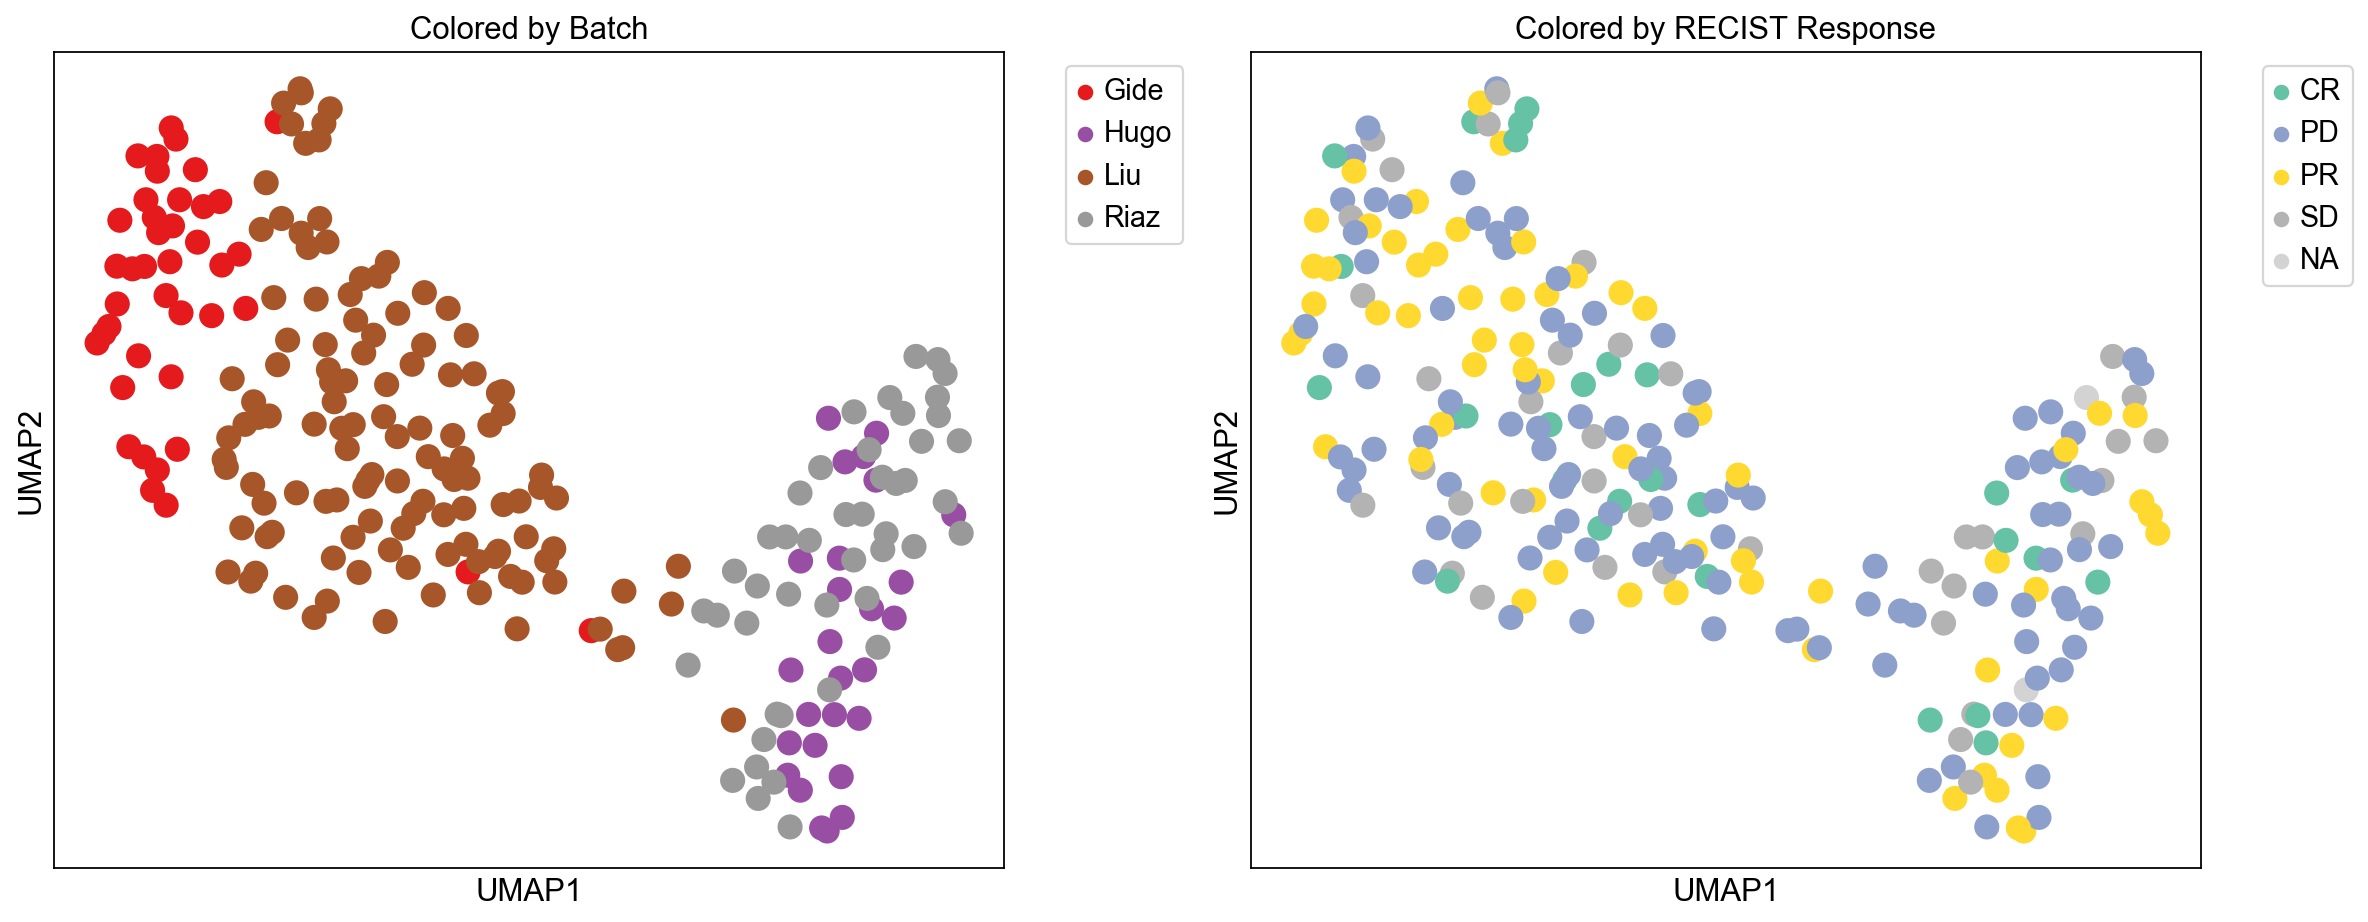

In [13]:
# Compute UMAP for visualization
print("="*50)
print("UMAP VISUALIZATION - BEFORE BATCH CORRECTION")
print("="*50)

# Compute neighborhood graph and UMAP
sc.pp.neighbors(adata_analysis, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_analysis)

# Create subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot by batch
sc.pl.umap(adata_analysis, color='batch', palette='Set1', ax=axes[0], show=False, title='Colored by Batch')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot by RECIST response
sc.pl.umap(adata_analysis, color='recist', palette='Set2', ax=axes[1], show=False, title='Colored by RECIST Response')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



AUTOMATED CLUSTERING - BEFORE BATCH CORRECTION
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Number of clusters found: 6


C:\Users\Marcos\AppData\Local\Temp\ipykernel_4120\434476450.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_analysis, resolution=0.5)


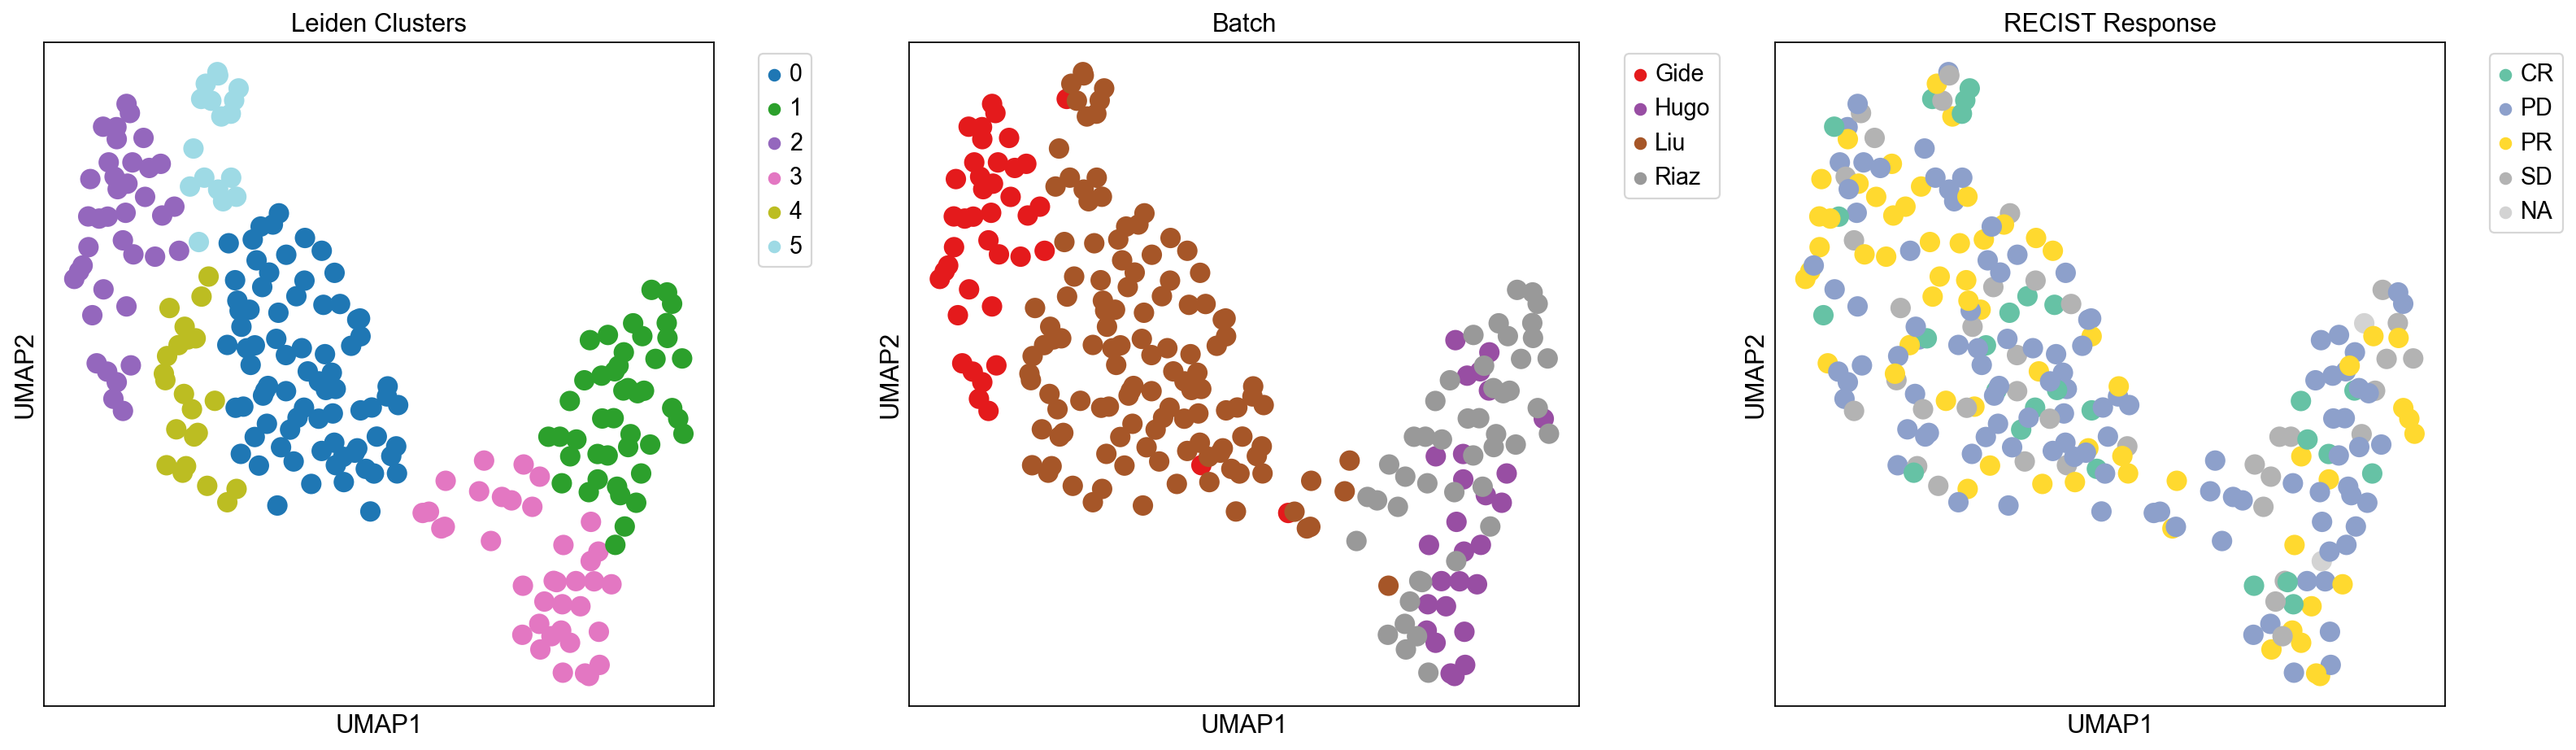


Cluster composition by batch:
batch   Gide  Hugo  Liu  Riaz
leiden                       
0          1     0   76     0
1          0    13    0    31
2         38     0    0     0
3          1    14    7    15
4          0     0   22     0
5          1     0   16     0

Cluster composition by RECIST:
recist  CR  PD  PR  SD
leiden                
0       10  37  18  12
1        5  22   8   8
2        3  15  15   5
3        3  17  10   6
4        2   9   6   5
5        4   6   5   2


In [14]:
# Automated clustering
print("="*50)
print("AUTOMATED CLUSTERING - BEFORE BATCH CORRECTION")
print("="*50)

# Leiden clustering
sc.tl.leiden(adata_analysis, resolution=0.5)
print(f"Number of clusters found: {len(adata_analysis.obs['leiden'].unique())}")

# Visualize clusters
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot clusters
sc.pl.umap(adata_analysis, color='leiden', palette='tab20', ax=axes[0], show=False, title='Leiden Clusters')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot batch again for comparison
sc.pl.umap(adata_analysis, color='batch', palette='Set1', ax=axes[1], show=False, title='Batch')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot RECIST again for comparison
sc.pl.umap(adata_analysis, color='recist', palette='Set2', ax=axes[2], show=False, title='RECIST Response')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Analyze cluster composition
print("\nCluster composition by batch:")
cluster_batch = pd.crosstab(adata_analysis.obs['leiden'], adata_analysis.obs['batch'])
print(cluster_batch)

print("\nCluster composition by RECIST:")
cluster_recist = pd.crosstab(adata_analysis.obs['leiden'], adata_analysis.obs['recist'])
print(cluster_recist)



In [15]:


# Create a copy for Combat correction
adata_combat = adata_analysis.copy()

# Prepare data for Combat
# Combat expects data as genes x samples, so we need to transpose
data_for_combat = adata_combat.X.T  # Transpose to genes x samples
batch_labels = adata_combat.obs['batch'].values


sc.pp.combat(adata_combat, key='batch')
    



Standardizing Data across genes.

Found 4 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [16]:
# Recompute embeddings after batch correction
print("="*50)
print("RECOMPUTING EMBEDDINGS AFTER BATCH CORRECTION")
print("="*50)

# Recompute PCA, neighbors, and UMAP on corrected data
print("Recomputing PCA...")
sc.tl.pca(adata_combat, svd_solver='arpack')

print("Recomputing neighborhood graph...")
sc.pp.neighbors(adata_combat, n_neighbors=10, n_pcs=30)

print("Recomputing UMAP...")
sc.tl.umap(adata_combat)



RECOMPUTING EMBEDDINGS AFTER BATCH CORRECTION
Recomputing PCA...
computing PCA
    with n_comps=50
    finished (0:00:00)
Recomputing neighborhood graph...
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
Recomputing UMAP...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


COMPARISON: BEFORE vs AFTER BATCH CORRECTION


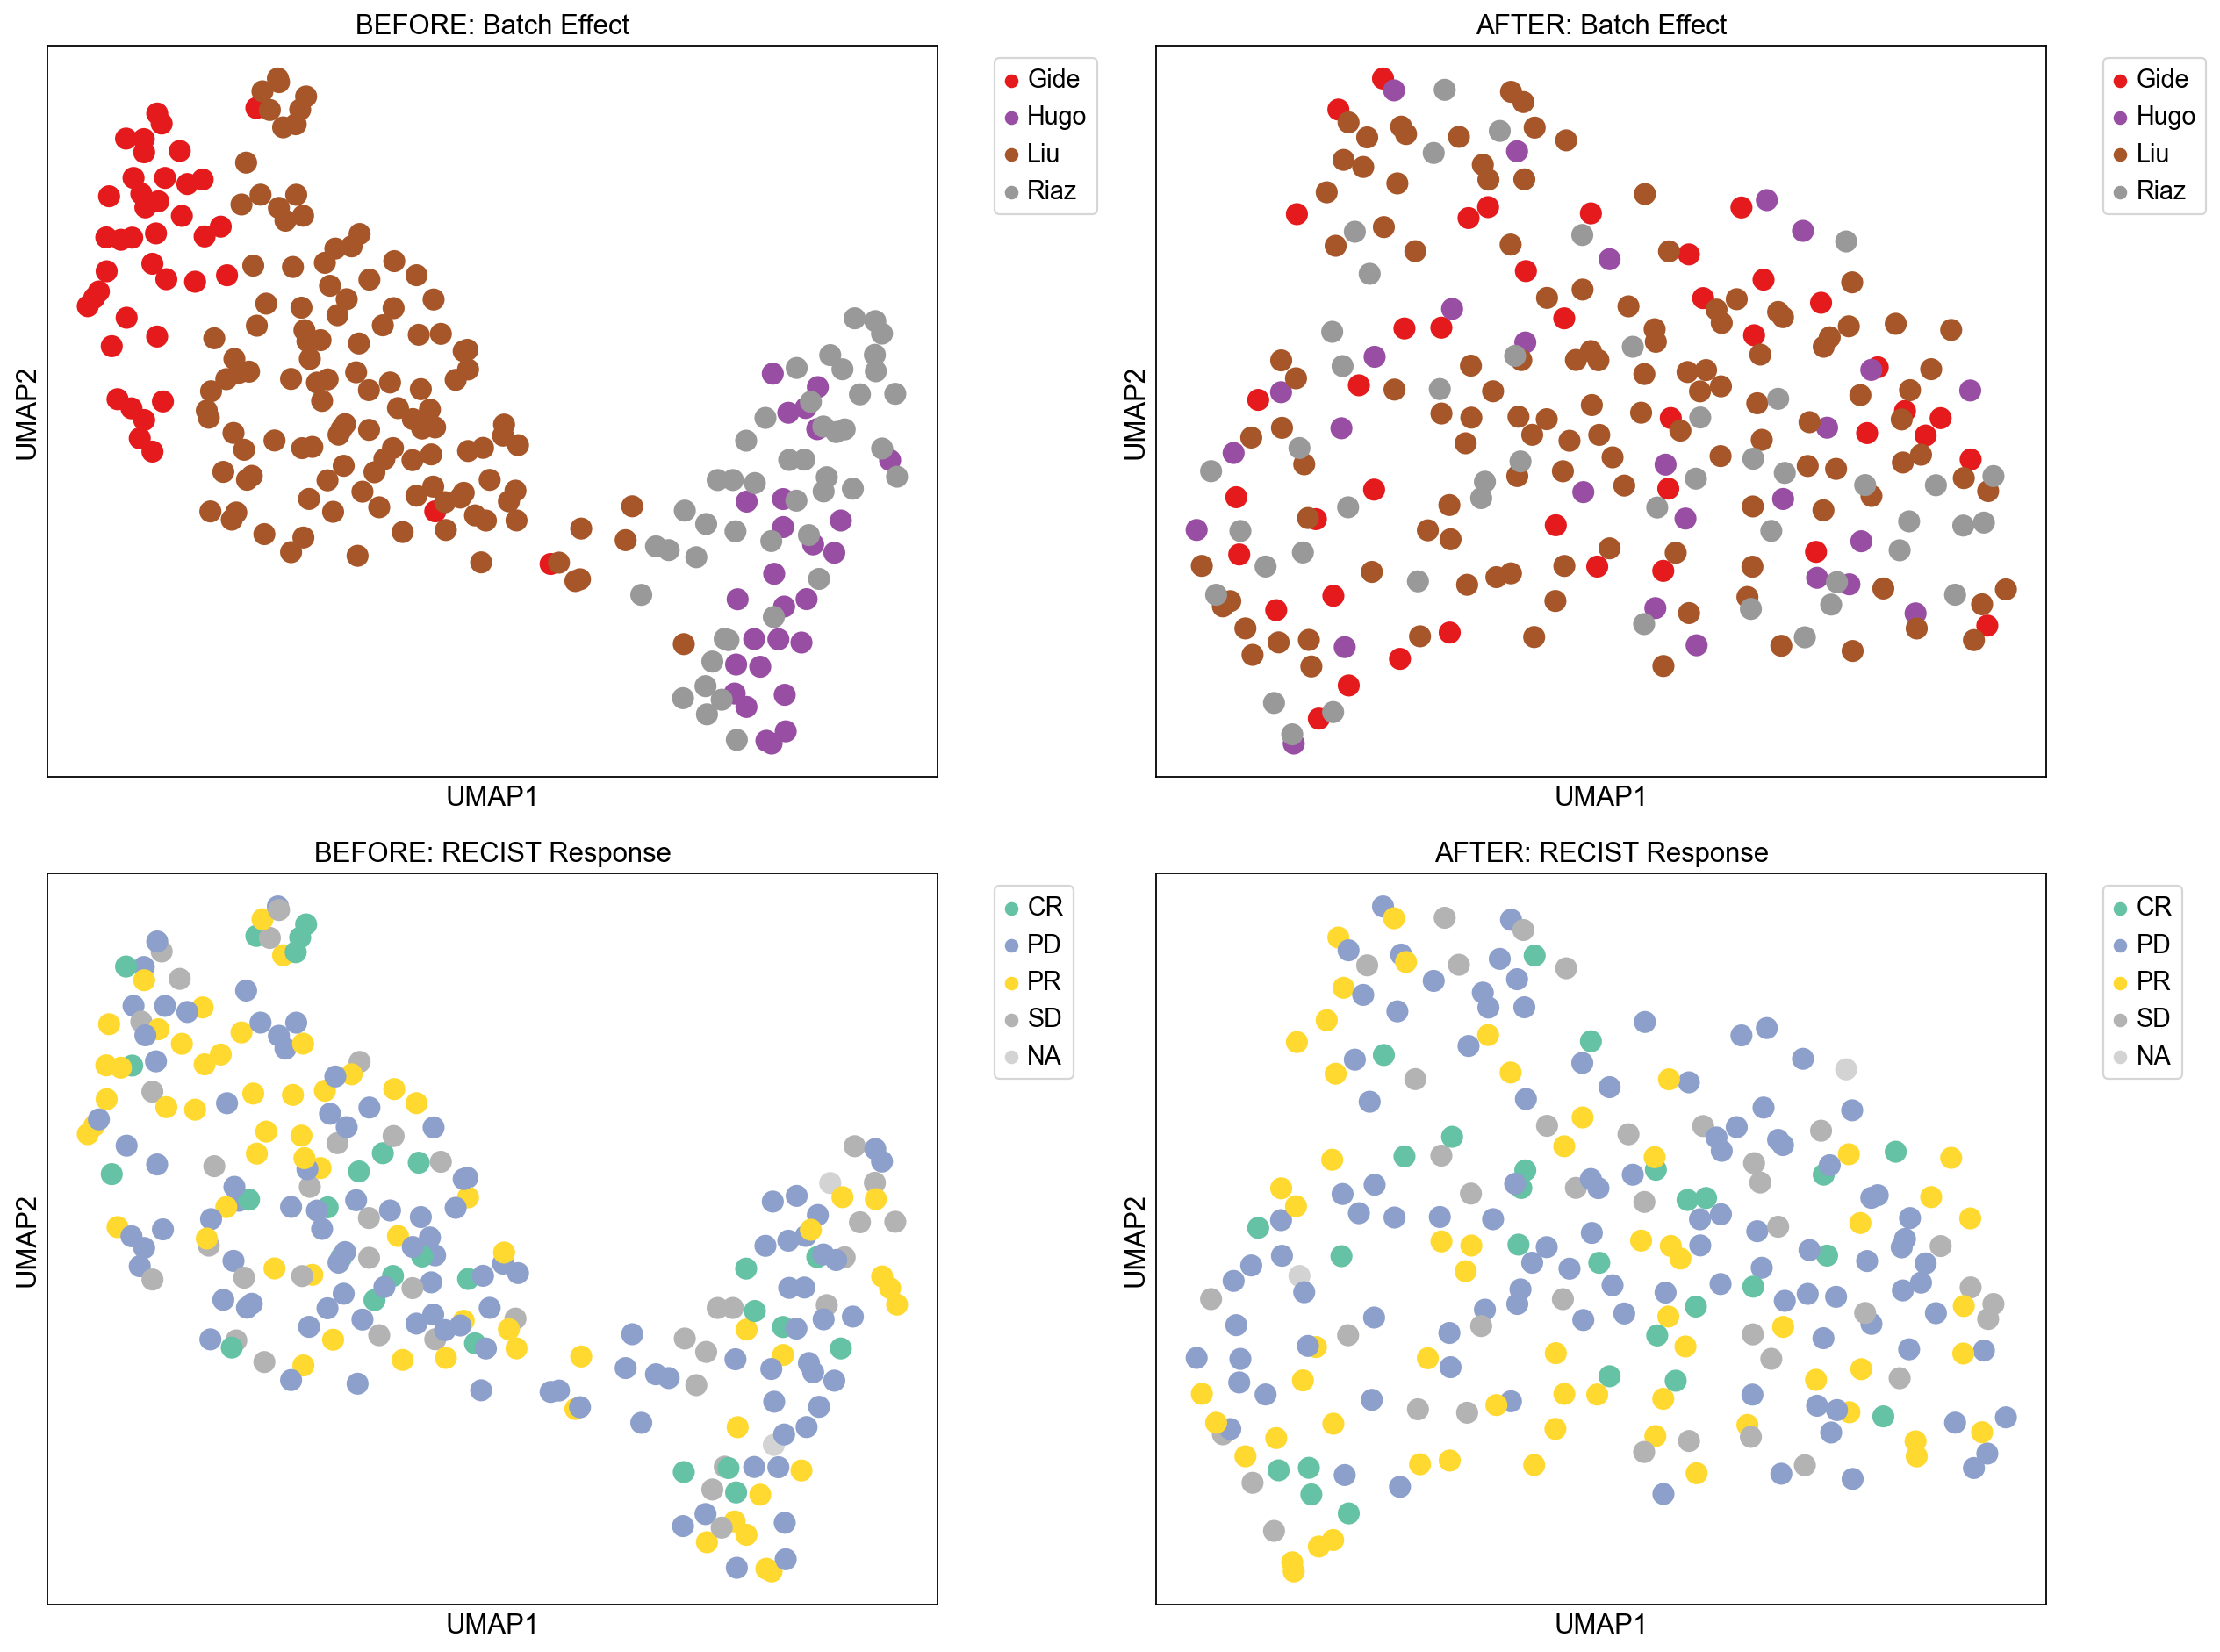

In [17]:
# Compare before and after batch correction
print("="*50)
print("COMPARISON: BEFORE vs AFTER BATCH CORRECTION")
print("="*50)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Before correction - Batch
sc.pl.umap(adata_analysis, color='batch', palette='Set1', ax=axes[0,0], show=False, title='BEFORE: Batch Effect')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# After correction - Batch
sc.pl.umap(adata_combat, color='batch', palette='Set1', ax=axes[0,1], show=False, title='AFTER: Batch Effect')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Before correction - RECIST
sc.pl.umap(adata_analysis, color='recist', palette='Set2', ax=axes[1,0], show=False, title='BEFORE: RECIST Response')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# After correction - RECIST
sc.pl.umap(adata_combat, color='recist', palette='Set2', ax=axes[1,1], show=False, title='AFTER: RECIST Response')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()




CLUSTERING AFTER BATCH CORRECTION
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_corrected', the cluster labels (adata.obs, categorical) (0:00:00)
Number of clusters after correction: 4


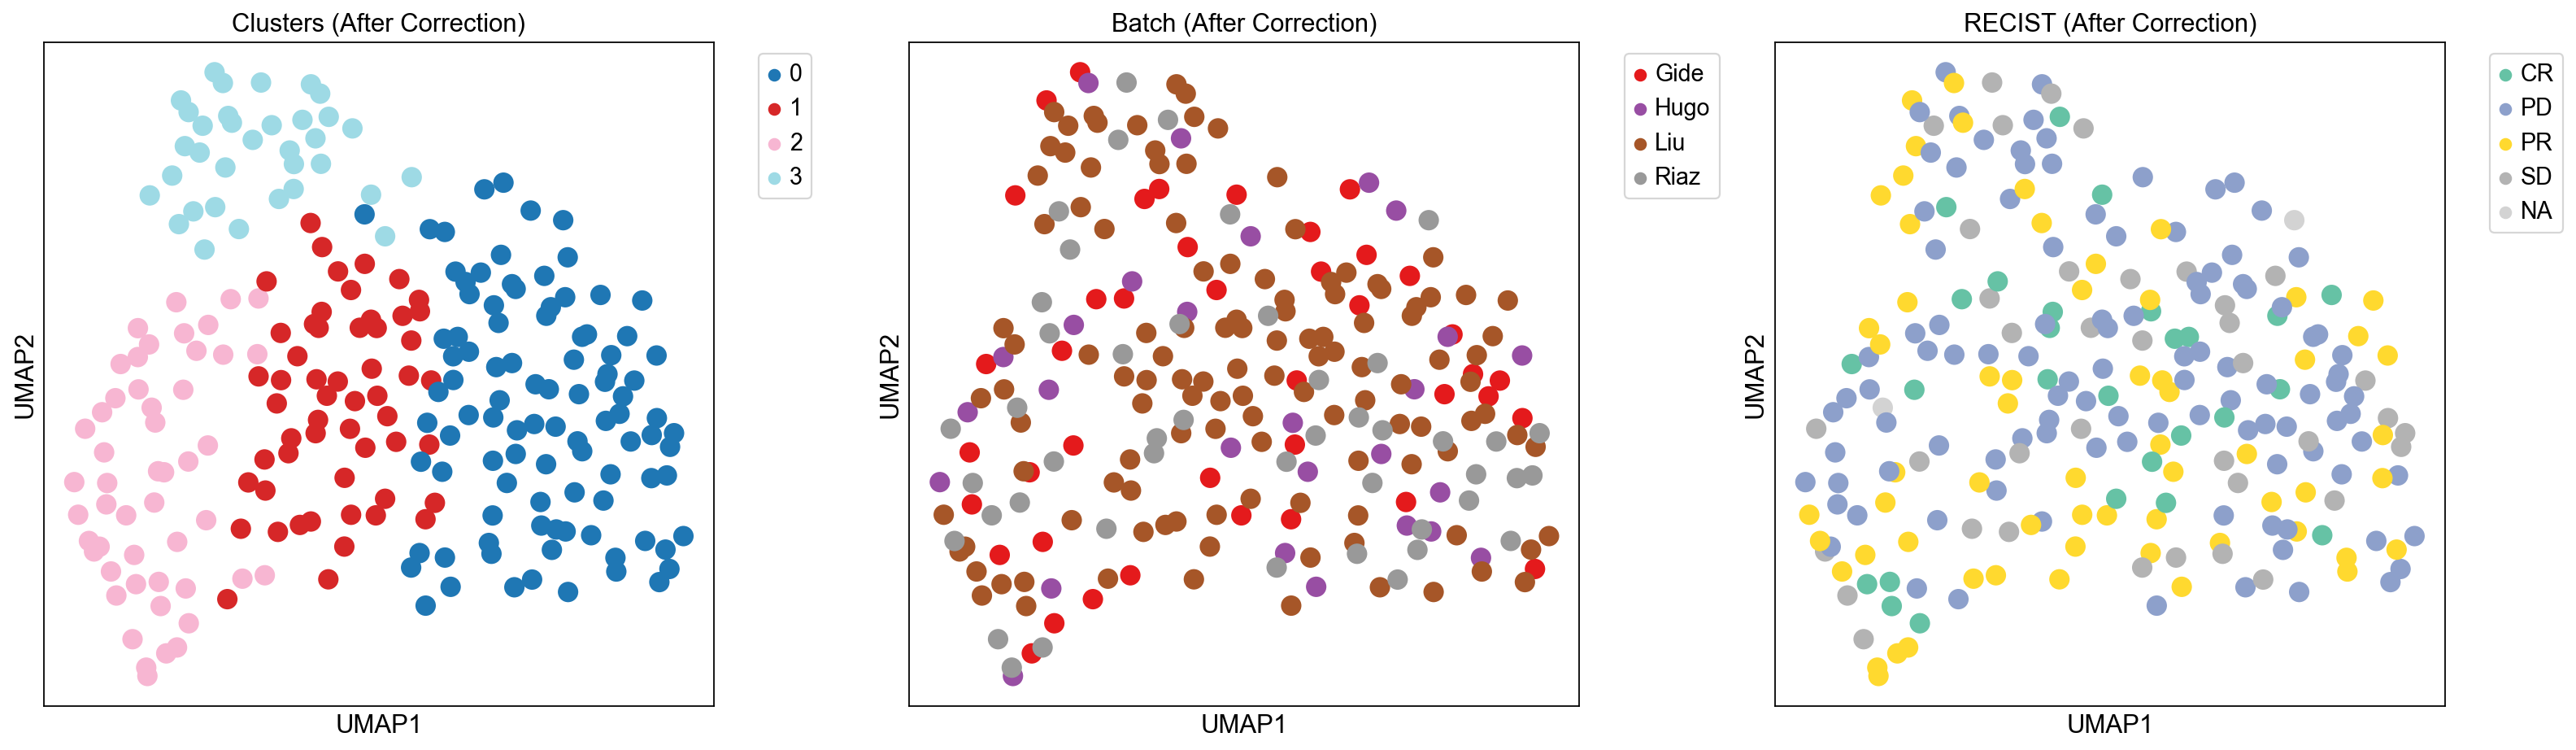


Cluster composition after correction:
By batch:
batch             Gide  Hugo  Liu  Riaz
leiden_corrected                       
0                   14    14   46    22
1                    8     3   38     6
2                   13     7   17    13
3                    6     3   20     5

By RECIST:
recist            CR  PD  PR  SD
leiden_corrected                
0                  9  49  20  17
1                  8  20  18   9
2                  7  20  16   6
3                  3  17   8   6

BATCH EFFECT ASSESSMENT
Batch separation (silhouette score):
  Before correction: 0.234
  After correction:  -0.024
  Change: -0.259 (negative is good)


In [18]:
# Final clustering after batch correction
print("="*50)
print("CLUSTERING AFTER BATCH CORRECTION")
print("="*50)

# Leiden clustering on corrected data
sc.tl.leiden(adata_combat, resolution=0.5, key_added='leiden_corrected')
print(f"Number of clusters after correction: {len(adata_combat.obs['leiden_corrected'].unique())}")

# Visualize corrected clustering
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot clusters after correction
sc.pl.umap(adata_combat, color='leiden_corrected', palette='tab20', ax=axes[0], show=False, title='Clusters (After Correction)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot batch (should be more integrated)
sc.pl.umap(adata_combat, color='batch', palette='Set1', ax=axes[1], show=False, title='Batch (After Correction)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot RECIST (biological signal should be preserved)
sc.pl.umap(adata_combat, color='recist', palette='Set2', ax=axes[2], show=False, title='RECIST (After Correction)')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Analyze new cluster composition
print("\nCluster composition after correction:")
print("By batch:")
cluster_batch_corrected = pd.crosstab(adata_combat.obs['leiden_corrected'], adata_combat.obs['batch'])
print(cluster_batch_corrected)

print("\nBy RECIST:")
cluster_recist_corrected = pd.crosstab(adata_combat.obs['leiden_corrected'], adata_combat.obs['recist'])
print(cluster_recist_corrected)

# Calculate batch mixing metrics
print("\n" + "="*50)
print("BATCH EFFECT ASSESSMENT")
print("="*50)

# Simple batch mixing assessment
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score

# Calculate silhouette score for batch separation (lower is better for integration)
batch_labels_numeric = pd.Categorical(adata_combat.obs['batch']).codes
sil_score_after = silhouette_score(adata_combat.obsm['X_umap'], batch_labels_numeric)

batch_labels_numeric_before = pd.Categorical(adata_analysis.obs['batch']).codes
sil_score_before = silhouette_score(adata_analysis.obsm['X_umap'], batch_labels_numeric_before)

print(f"Batch separation (silhouette score):")
print(f"  Before correction: {sil_score_before:.3f}")
print(f"  After correction:  {sil_score_after:.3f}")
print(f"  Change: {sil_score_after - sil_score_before:.3f} (negative is good)")




In [22]:
print("="*50)
print("SAVING BATCH CORRECTED DATA")
print("="*50)

# Combine expression data with clinical metadata
expression_data = pd.DataFrame(
    adata_combat.X, 
    index=adata_combat.obs_names, 
    columns=adata_combat.var_names
)

# Combine with clinical data
combined_data = pd.concat([adata_combat.obs[['recist']], expression_data], axis=1)

# Save to CSV
output_file = "../../data/melanoma_batch_corrected_data_common_genes_cosmic_io.csv"
combined_data.to_csv(output_file, index=True)

print(f"✓ Batch corrected data saved to: {output_file}")
print(f"Data shape: {combined_data.shape}")
print(f"Columns: {len(adata_combat.obs.columns)} clinical + {len(adata_combat.var_names)} genes")
print(f"Patients: {len(combined_data)}")
print(f"File size: ~{combined_data.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")

SAVING BATCH CORRECTED DATA
✓ Batch corrected data saved to: ../../data/melanoma_batch_corrected_data_common_genes_cosmic_io.csv
Data shape: (235, 214)
Columns: 97 clinical + 213 genes
Patients: 235
File size: ~0.4 MB


In [52]:
df = pd.read_csv(output_file, header=0)

# Remove rows where the target variable (recist) has NaN values
df = df.dropna(subset=['recist'])
print(f"Data shape after removing NaN values in target: {df.shape}")
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

Data shape after removing NaN values in target: (233, 215)


In [ ]:
# Create a mapping from unique response labels to integers
unique_labels = pd.Series(y).dropna().unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}
print(label_map)
# Map the response labels in y to integers using label_map
y_mapped = pd.Series(y).map(label_map).values
print(y_mapped)




{'PD': 0, 'SD': 1, 'PR': 2, 'CR': 3}
[0 0 1 0 0 0 0 0 0 1 0 1 1 2 2 1 0 2 2 2 2 2 2 3 2 2 2 2 2 3 0 3 2 3 2 0 0
 0 1 0 0 0 2 2 2 2 0 3 3 0 0 3 0 2 0 2 0 0 0 0 3 2 0 0 0 2 2 2 2 1 1 3 2 0
 2 0 0 0 0 2 3 2 3 0 2 3 0 0 3 3 0 0 2 1 0 2 3 3 3 2 1 0 2 1 0 0 2 1 2 0 0
 0 2 0 2 2 1 1 0 2 1 3 0 3 1 3 0 0 0 0 2 0 0 0 2 0 1 0 0 2 2 1 0 0 0 0 3 2
 2 0 0 3 2 0 1 2 0 0 1 0 0 2 0 0 0 1 0 0 1 2 1 0 3 0 2 0 0 2 2 0 0 0 1 2 0
 2 3 0 0 0 1 0 1 1 2 0 0 1 2 0 0 1 3 1 1 0 1 0 1 2 0 0 1 0 1 0 2 1 3 1 0 0
 0 0 3 0 0 0 1 0 2 0 2]


In [48]:
# Map the response labels in y to integers using label_map
y_mapped = pd.Series(y).map(label_map).values
print(y_mapped)

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  2.  2.  1.  0.  2.
  2.  2.  2.  2.  2.  3.  2.  2.  2.  2.  2.  3.  0.  3.  2.  3.  2.  0.
  0.  0.  1.  0.  0.  0.  2.  2.  2.  2.  0.  3.  3.  0.  0.  3.  0.  2.
  0.  2.  0.  0.  0.  0.  3.  2.  0.  0.  0.  2.  2.  2.  2.  1.  1.  3.
  2.  0.  2.  0.  0.  0.  0.  2.  3.  2.  3.  0.  2.  3.  0.  0.  3.  3.
  0.  0.  2.  1.  0.  2.  3.  3.  3.  2.  1.  0.  2.  1.  0.  0.  2.  1.
  2.  0.  0.  0.  2.  0.  2.  2.  1.  1.  0.  2.  1.  3.  0.  3.  1.  3.
  0.  0.  0.  0.  2.  0.  0.  0.  2.  0.  1.  0.  0.  2.  2.  1.  0.  0.
  0.  0.  3.  2.  2.  0.  0.  3.  2.  0.  1.  2.  0.  0.  1.  0.  0.  2.
  0.  0.  0.  1.  0.  0.  1.  2.  1.  0.  3.  0.  2.  0.  0.  2.  2.  0.
  0.  0.  1.  2.  0.  2.  3.  0.  0.  0.  1. nan  0.  1.  1.  2.  0. nan
  0.  1.  2.  0.  0.  1.  3.  1.  1.  0.  1.  0.  1.  2.  0.  0.  1.  0.
  1.  0.  2.  1.  3.  1.  0.  0.  0.  0.  3.  0.  0.  0.  1.  0.  2.  0.
  2.]
